# LoC image analysis

This notebook is designed to take the raw output of a LoC data set, monolayer or bilayer, and:
 (trying to check if dask multichan works)

5. Localise and measure properties
6. Unite the localisations over the z-range
7. Save out the Z-tracks
8. Extract the maximum intensity from each cell

In [1]:
import os
import glob
from octopusheavy import DaskOctopusHeavyLoader
import napari
from skimage.io import imshow,  imsave, imread
import napari
import btrack
from tqdm.auto import tqdm
import dask.array as da

# Loading images

Define root path and individual experiment IDs

In [2]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'

In [3]:
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

## Check to see what channels each expt has

In [4]:
for i, expt in enumerate(expt_IDs):
    images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
    if 'MASK1' in [channel.name for channel in images.channels]:
        images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
        print(i, images.channels)

0 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
1 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
2 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
3 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
4 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
5 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]


In [5]:
images['CH1']

dask.array<stack, shape=(81, 2304, 2304), dtype=uint16, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

### Defining properties to measure similarities of z-slices

In [6]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         #'intensity_image', 
         'orientation',
         'mean_intensity')

# I think if this one doesn't work it's due to the filename... but surely because I'm reading images from that address then the filepath works...?

In [7]:
for i, expt in tqdm(enumerate(expt_IDs), total = len(expt_IDs)):
    print(i)
    props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         #'intensity_image', 
         'orientation',
         'mean_intensity')
    images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
    multichannel_stack = da.stack([images['CH1'], images['CH2'], images['CH3'], images['CH4']], axis = -1)
    if 'MASK1' in [channel.name for channel in images.channels]: 
        ### create filename for tracks and objects 
        dirname = os.path.dirname(images.files('CH1')[0]).replace('images','')
        objects_fn = os.path.join(dirname, 'objects.hdf5')
        tracks_fn = os.path.join(dirname, 'tracks.hdf5')
        ### try saving locally instead of online
        tracks_fn = tracks_fn.split('Light microscopy/')[-1].replace('/', '_')
        objects_fn = objects_fn.split('Light microscopy/')[-1].replace('/', '_')
        objects = btrack.utils.segmentation_to_objects(
            images['MASK1'], 
            multichannel_stack,
            properties = props,#('area', 'mean_intensity', 'intensity_image'), 
            use_weighted_centroid = False
        )
        ### prune objects 
        objects = [o for o in objects if o.properties['area']>50]
        ### save out objects
        with btrack.dataio.HDF5FileHandler(
             objects_fn, 'w', obj_type='obj_type_1',
        ) as hdf:
            hdf.write_segmentation(images['MASK1'])
            hdf.write_objects(objects)
        
        ### redefine properties as multichannel image was measured
        props = ('axis_major_length', 
             'axis_minor_length', 
             'eccentricity', 
             'area', 
             #'intensity_image', 
             'orientation',
             'mean_intensity-0',
             'mean_intensity-1',
             'mean_intensity-2',
             'mean_intensity-3',)
        # initialise a tracker session using a context manager
        with btrack.BayesianTracker() as tracker:
            # configure the tracker using a config file
            tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
            tracker.verbose = True
            ### set max search radius
            tracker.max_search_radius = 100
            # use visual features to track
            tracker.features = props
            # append the objects to be tracked
            tracker.append(objects)
            # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
            tracker.volume=((0, 2304), (0, 2304), (-1e5, 1e5))
            # track them (in interactive mode)
#             tracker.track_interactive(step_size=100)
            tracker.track(tracking_updates =['visual', 'motion'], step_size=10)
            # generate hypotheses and run the global optimizer
            tracker.optimize()
            # get the tracks as a python list
            tracks = tracker.tracks
#             # filter tracks
#             tracks = [track for track in tracks if len(track) >= 3]
            # optional: get the data in a format for napari
            #   data, properties, graph = tracker.to_napari()
            tracker.export(tracks_fn, obj_type = 'obj_type_1')
    break             

  0%|          | 0/6 [00:00<?, ?it/s]

0


[INFO][2023/01/10 10:22:43 AM] Localizing objects from segmentation...
[INFO][2023/01/10 10:22:43 AM] Found intensity_image data
[INFO][2023/01/10 10:24:54 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/10 10:24:55 AM] ...Found 30362 objects in 68 frames.
[INFO][2023/01/10 10:24:55 AM] Opening HDF file: co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__objects.hdf5...
[INFO][2023/01/10 10:25:24 AM] Writing objects/obj_type_1
[INFO][2023/01/10 10:25:24 AM] Writing labels/obj_type_1
[INFO][2023/01/10 10:25:24 AM] Loading objects/obj_type_1 (29046, 5) (29046 filtered: None)
[INFO][2023/01/10 10:25:24 AM] Writing properties/obj_type_1/axis_major_length (29046,)
[INFO][2023/01/10 10:25:24 AM] Writing properties/obj_type_1/axis_minor_length (29046,)
[INFO][2023/01/10 10:25:24 AM] Writing properties/obj_type_1/eccentricity (29046,)
[INFO][2023/01/10 10:25:24 AM] Writing properties

GLPK Integer Optimizer 5.0
16212 rows, 12600 columns, 17094 non-zeros
12600 integer variables, all of which are binary
Preprocessing...
8106 rows, 12600 columns, 17094 non-zeros
12600 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8106
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
8106 rows, 12600 columns, 17094 non-zeros
*     0: obj =   5.291086383e+04 inf =   0.000e+00 (1665)
Perturbing LP to avoid stalling [741]...
Removing LP perturbation [1645]...
*  1645: obj =   4.357230139e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  1645: mip =     not found yet >=              -inf        (1; 0)
+  1645: >>>>>   4.357230139e+04 >=   4.357230139e+04   0.0% (1; 0)
+  1645: mip =   4.357230139e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL

[WARNING][2023/01/10 10:26:41 AM] Changing HDF filename to co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.h5
[INFO][2023/01/10 10:26:41 AM] Opening HDF file: co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.h5...
[INFO][2023/01/10 10:26:41 AM] Writing tracks/obj_type_1
[WARNING][2023/01/10 10:26:41 AM] Removing tracks/obj_type_1.
[INFO][2023/01/10 10:26:41 AM] Writing dummies/obj_type_1
[INFO][2023/01/10 10:26:41 AM] Writing LBEP/obj_type_1
[INFO][2023/01/10 10:26:41 AM] Writing fates/obj_type_1
[INFO][2023/01/10 10:26:41 AM] Closing HDF file: co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.h5
[INFO][2023/01/10 10:26:41 AM] Ending BayesianTracker 

In [8]:
import matplotlib.pyplot as plt

(array([4.615e+03, 1.675e+03, 2.279e+03, 6.410e+02, 3.230e+02, 2.300e+02,
        7.500e+01, 5.000e+01, 1.100e+01, 2.000e+00]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <BarContainer object of 10 artists>)

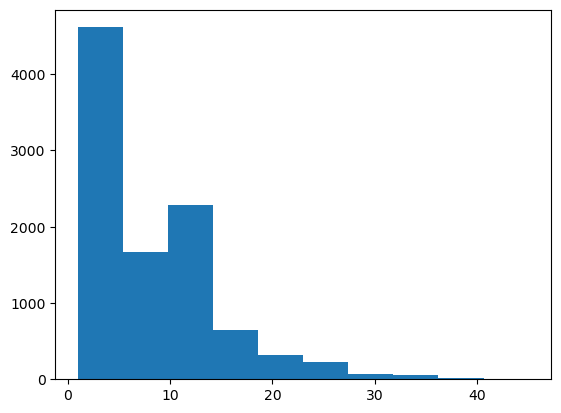

In [9]:
plt.hist([len(track) for track in tracks])

In [10]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_minor_length,mean_intensity-1,mean_intensity-2,mean_intensity-0,eccentricity,mean_intensity-3,area,orientation,axis_major_length
0,93,0,1128.883333,3.766667,0.0,93,93,5,0,False,"(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array"


In [11]:
tracks[30]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_minor_length,mean_intensity-1,mean_intensity-2,mean_intensity-0,eccentricity,mean_intensity-3,area,orientation,axis_major_length
0,80,0,1850.238806,998.253731,0.000000,80,80,5,0,False,9.301548,123.149254,168.238806,113.223881,0.760922,137.119403,67.0,-1.457316,14.335579
1,80,1,1850.238806,998.253731,0.000000,80,80,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80,2,1827.879518,1010.843373,0.000000,80,80,5,0,False,9.846851,127.108434,177.927711,114.674699,0.576047,142.722892,83.0,-0.748999,12.046309
3,80,3,1825.228571,977.171429,0.000000,80,80,5,0,False,11.378606,111.021429,116.878571,110.142857,0.763034,133.142857,140.0,0.060647,17.604173
4,80,4,1825.228571,977.171429,0.000000,80,80,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,80,5,1825.228571,977.171429,0.000000,80,80,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,80,6,1825.686957,976.060870,0.000000,80,80,5,0,False,10.462208,111.730435,120.469565,110.939130,0.717313,133.573913,115.0,0.147468,15.015709
7,80,7,1823.177419,974.935484,0.000000,80,80,5,0,False,6.588535,114.838710,121.790323,109.322581,0.876637,133.580645,62.0,-0.745334,13.693241
8,80,8,1822.317073,973.926829,0.000000,80,80,5,0,False,8.213110,114.621951,122.207317,113.780488,0.784674,134.317073,82.0,-0.265188,13.248906
9,80,9,1821.264000,967.480000,0.000000,80,80,5,0,False,8.524525,115.576000,120.928000,120.592000,0.892714,130.248000,125.0,-0.640915,18.917160


# It won't let me save tracks to the server? But will let me save locally

In [35]:
tracks_fn = 'co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.hdf5'

In [38]:
with btrack.dataio.HDF5FileHandler(tracks_fn.replace('hdf5','csv'), "w", obj_type="obj_type_1") as hdf:
    hdf.write_tracks(tracks)

[INFO][2022/12/02 02:56:41 pm] Opening HDF file: co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.csv...
02-Dec-22 14:56:41 - btrack.dataio - INFO     - Opening HDF file: co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.csv...
[INFO][2022/12/02 02:56:42 pm] Writing objects/obj_type_1
02-Dec-22 14:56:42 - btrack.dataio - INFO     - Writing objects/obj_type_1
[INFO][2022/12/02 02:56:42 pm] Writing labels/obj_type_1
02-Dec-22 14:56:42 - btrack.dataio - INFO     - Writing labels/obj_type_1
[INFO][2022/12/02 02:56:42 pm] Loading objects/obj_type_1 (59338, 5) (59338 filtered: None)
02-Dec-22 14:56:42 - btrack.dataio - INFO     - Loading objects/obj_type_1 (59338, 5) (59338 filtered: None)
[INFO][2022/12/02 02:56:42 pm] Writing properties/obj_type_1/axis_major_length (

# Hacky fix for JAKSON

In [23]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_major_length,mean_intensity-0,mean_intensity-3,mean_intensity-1,mean_intensity-2,area,axis_minor_length,orientation,eccentricity
0,93,0,1128.883333,3.766667,0.0,93,93,5,0,False,"(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array"


In [126]:
data, new_properties, new_graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

In [16]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

In [17]:
for i, expt in enumerate(expt_IDs):
    images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
    if 'MASK1' in [channel.name for channel in images.channels]:
        images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
        print(i, images.channels)
        dirname = os.path.dirname(images.files('CH1')[0]).replace('images','')
        tracks_fn = os.path.join(dirname, 'tracks.h5')
        tracks_fn = tracks_fn.split('Light microscopy/')[-1].replace('/', '_')
#         tracks_fn = os.path.join(root_path, expt.replace('images/', 'tracks.hdf5'))
        print('Tracks exist:', os.path.exists(tracks_fn))

0 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
Tracks exist: True
1 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
Tracks exist: True
2 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
Tracks exist: True
3 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
Tracks exist: True
4 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
Tracks exist: True
5 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>, <Channels.MASK1: 99>]
Tracks exist: True


In [18]:
expt = expt_IDs[0]
images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)

In [13]:
import enum
@enum.unique
class Channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 1
    SPC = 2
    PDPN = 3
    ZO1 = 4

In [20]:
output_dir = f'/home/dayn/data/lung_on_chip/pos_neg_dist/{expt}jakson'
if not os.path.exists(output_dir):
    os.makedirs(output_dir,)

In [127]:
v = napari.Viewer()

v.add_image(images['CH1'], name = Channels.DAPI.name, blending = 'additive', colormap='blue', visible = False)
v.add_image(images['CH2'], name = Channels.SPC.name, blending = 'additive', colormap='green')
v.add_image(images['CH3'], name = Channels.PDPN.name, blending = 'additive', colormap='red')
v.add_image(images['CH4'], name = Channels.ZO1.name, blending = 'additive', colormap='gray', visible = False)
v.add_labels(images['MASK1'], visible=True)
tracker_layer = v.add_tracks(data, tail_length=0, visible = False)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encounte

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

In [26]:
v = napari.Viewer()

v.add_image(images['CH1'], name = Channels.DAPI.name, blending = 'additive', colormap='blue', visible = False)
v.add_image(images['CH2'], name = Channels.SPC.name, blending = 'additive', colormap='green')
v.add_image(images['CH3'], name = Channels.PDPN.name, blending = 'additive', colormap='red')
v.add_image(images['CH4'], name = Channels.ZO1.name, blending = 'additive', colormap='gray', visible = False)
v.add_labels(images['MASK1'], visible=True)
tracker_layer = v.add_tracks(data, tail_length=0, visible = False)

@v.bind_key('t')
def SPC_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "SPC_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "SPC_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('b')
def SPC_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "SPC_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "SPC_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

@v.bind_key('p')
def NKX21_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "NKX21_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "NKX21_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('n')
def NKX21_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "NKX21_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "NKX21_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('q')
def PDPN_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-2'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "PDPN_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "PDPN_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('c')
def PDPN_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-2'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "PDPN_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "PDPN_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encounte

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

In [39]:
output_dir = f'/home/dayn/data/lung_on_chip/pos_neg_dist/{expt}gabriel'
if not os.path.exists(output_dir):
    os.makedirs(output_dir,)

In [41]:
v = napari.Viewer()

v.add_image(images['CH1'], name = Channels.DAPI.name, blending = 'additive', colormap='blue', visible = False)
v.add_image(images['CH2'], name = Channels.SPC.name, blending = 'additive', colormap='green')
v.add_image(images['CH3'], name = Channels.PDPN.name, blending = 'additive', colormap='red')
v.add_image(images['CH4'], name = Channels.ZO1.name, blending = 'additive', colormap='gray', visible = False)
v.add_labels(images['MASK1'], visible=True)
tracker_layer = v.add_tracks(data, tail_length=0, visible = False)

@v.bind_key('t')
def SPC_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "SPC_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "SPC_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('b')
def SPC_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "SPC_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "SPC_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

@v.bind_key('p')
def NKX21_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "NKX21_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "NKX21_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('n')
def NKX21_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "NKX21_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "NKX21_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('q')
def PDPN_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-2'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "PDPN_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "PDPN_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@v.bind_key('c')
def PDPN_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=v.cursor.position)
    ### get time frame
    time = v.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-2'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "PDPN_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "PDPN_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encounte

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (


Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: The `as_dict` kwarg default to False` since Napari 0.4.17, and will become a mandatory parameter in the future.
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/menus/plugins_menu.py", line 99, in _add_toggle_widget
    self._win.add_plugin_dock_widget(*key)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 717, in add_plugin_dock_widget
    wdg = _instantiate_dock_widget(
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 1365, in _instantiate_dock_widget
    return wdg_cls(**kwargs)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_animation/_qt/animation_widget.py", line 44, in __init__
    self._i

## Checking tracks prior to plotting single cell info

In [ ]:
import napari

In [124]:
viewer = napari.Viewer()

viewer.add_image(ch0, colormap='blue', blending = 'additive')
viewer.add_image(ch3, colormap= 'gray', blending = 'additive')
viewer.add_image(ch1, colormap='red', blending = 'additive')
viewer.add_image(ch2, colormap= 'green', blending = 'additive')

viewer.add_labels(mask_stack)

viewer.add_tracks(ch1_data)
viewer.add_tracks(ch2_data)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


NameError: name 'ch0' is not defined

# Extracting single cell info

(array([4.615e+03, 1.675e+03, 2.279e+03, 6.410e+02, 3.230e+02, 2.300e+02,
        7.500e+01, 5.000e+01, 1.100e+01, 2.000e+00]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <BarContainer object of 10 artists>)

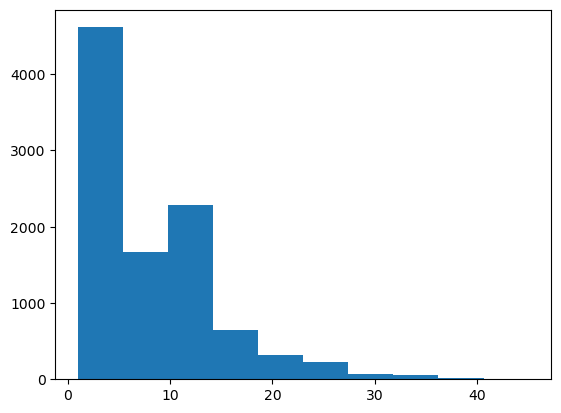

In [16]:
plt.hist([len(track) for track in tracks])

In [17]:
filtered_tracks = [track for track in tracks if len(track) >3]

In [36]:
import numpy as np
import pandas as pd

In [32]:
class channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 0
    SPC = 1
    PDPN = 2
    ZO1 = 3

In [37]:
### define parameters to plot in table
cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
### extract some intial measurements
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in filtered_tracks], columns= cols)

In [38]:
df

,Cell ID,Max. int. DAPI,Max. int. SPC,Max. int. PDPN,Max. int. ZO1,Average X,Average Y
0,84,216.148137,256.254388,708.973764,304.946782,1775.768867,1033.838209
1,76,132.621622,173.988072,217.620278,208.888668,2089.845109,887.967882
2,70,128.000000,117.615385,125.815385,124.948052,2078.486081,8.384449
3,71,106.754902,113.752212,132.044248,136.707965,2101.134548,5.889780
4,72,111.000000,152.245763,284.720339,148.432203,1794.412976,520.435074
...,...,...,...,...,...,...,...
6104,11533,105.372881,108.620253,109.379747,115.443038,705.839573,4.299024
6105,11527,105.321678,113.662420,113.318471,121.121019,2297.713839,1453.302570
6106,11526,106.464286,113.160714,112.660714,123.206897,2297.784021,1439.364378
6107,11522,107.577869,118.851485,117.137931,125.068966,6.549068,1290.065281


# Calculating the number of cells above/below threshold

In [39]:
pdpn_thresh = 400
spc_thresh = 350

In [42]:
print(f'Number of PDPN positive cells:', len(df[df['Max. int. PDPN'] > pdpn_thresh]))
print(f'Number of PDPN negative cells:', len(df[df['Max. int. PDPN'] < pdpn_thresh]))
print(f'Number of SPC positive cells:', len(df[df['Max. int. PDPN'] > spc_thresh]))
print(f'Number of SPC negative cells:', len(df[df['Max. int. PDPN'] < spc_thresh]))

Number of PDPN positive cells: 1951
Number of PDPN negative cells: 4158
Number of SPC positive cells: 3127
Number of SPC negative cells: 2982


## Distribution of maximum pixel values

In [44]:
import seaborn as sns

In [51]:
help(sns.histplot)

Help on function histplot in module seaborn.distributions:

histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    Plot univariate or bivariate histograms to show distributions of datasets.
    
    A histogram is a classic visualization tool that represents the distribution
    of one or more variables by counting the number of observations that fall within
    disrete bins.
    
    This function can normalize the statistic computed within each bin to estimate
    frequency, density or probability mass, and it can add a smooth curve obtained
    using a kernel density estimate,

In [114]:
percentage_pos_pdpn = round(len(df[df['Max. int. PDPN'] > pdpn_thresh])/len(df)*100, 2)

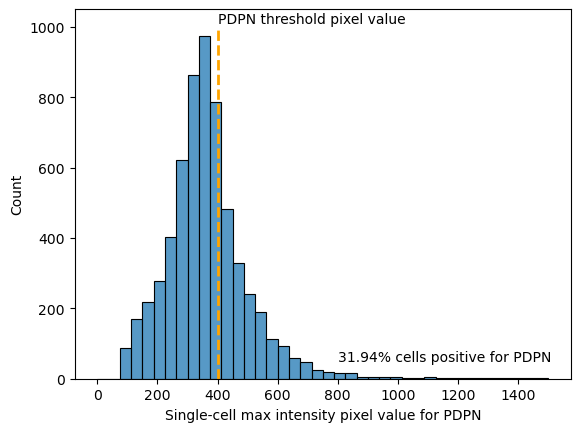

In [120]:
sns.histplot(df['Max. int. PDPN'], binrange=(0,1500), bins = 40, kde=False)
plt.vlines(x=pdpn_thresh, ymin = 0, ymax = 1000, linewidth = 2, color = 'orange', linestyle = 'dashed')
plt.text(x = pdpn_thresh, y = 1010, s = 'PDPN threshold pixel value')
plt.text(x = 800, y = 50, s = f'{percentage_pos_pdpn}% cells positive for PDPN')
plt.xlabel('Single-cell max intensity pixel value for PDPN')
plt.savefig('/home/dayn/data/lung_on_chip/coculture/DAPI-SPC-PDPN-ZO1_20220808/dist_max_pixel_values_pdpn.jpg', dpi = 314, bbox_inches = 'tight')

In [116]:
percentage_pos_spc = round(len(df[df['Max. int. SPC'] > spc_thresh])/len(df)*100, 2)

In [ ]:
/mnt/DATA/lung_on_chip/single_cell_px_int/per_expt_dist_thresholds/NKX21_expt_-21-12-028A-236-_thresh_sc_px_int.jpg

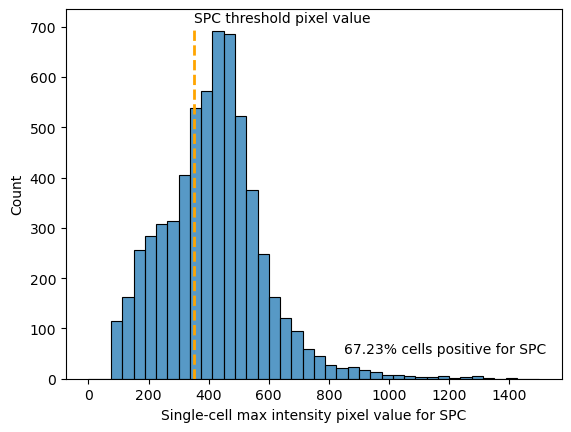

In [123]:
sns.histplot(df['Max. int. SPC'], binrange=(0,1500), bins = 40, kde=False)
plt.vlines(x=spc_thresh, ymin = 0, ymax = 700, linewidth = 2, color = 'orange', linestyle = 'dashed')
plt.text(x = spc_thresh, y = 710, s = 'SPC threshold pixel value')
plt.text(x = 850, y = 50, s = f'{percentage_pos_spc}% cells positive for SPC')
plt.xlabel('Single-cell max intensity pixel value for SPC')
plt.savefig('/home/dayn/data/lung_on_chip/coculture/DAPI-SPC-PDPN-ZO1_20220808/dist_max_pixel_values_spc.jpg', dpi = 314, bbox_inches = 'tight')